In [1]:
import numpy as np
import numpy.matlib
import pandas as pd
from time import time
from collections import defaultdict, Counter
import sys
import os
import math
import matplotlib.pyplot as plt

import torch
from argparse import Namespace

In [2]:
args = Namespace(
    # определение устройства на котором будут производиться рассчеты
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    # информация о данных и путях
    pathToFile_csv = 'learning_itemData_172_week_2021-03-31 .csv',
    vectorizer_file = "vectorizer.json",
    model_state_file = "model.pth",
    save_dir = "C:\\Users\\MKoga\\MyProgramms\\BusinessAnalysis",
    train_proportion = 0.05,
    val_proportion = 0.05,
    test_proportion = 0.9,
    # Гиперпараметры модели
    rnn_hidden_size = 180,
    # hidden_dim = ...
    # Гиперпараметры обучения
    seed = 1234,
    num_epochs = 25,
    learning_rate = 8e-5,
    num_layers = 2,
    batch_size = 32,
    logNormToNormData = lambda x : np.log(x + np.exp(1)),
    normToLogNormData = lambda x : np.exp(x) - np.exp(1),

)

idx = pd.IndexSlice

Сгенерировать новые данные на базе существующих. Добавлением шума (случайные сдвиги продаж на 1 еденицу +-). Перестановка недель (и пар ближайших недель) продаж. Разыгрывание переставляемых недель с вероятностью уменьшающейся от растояния в неделях.

# N(μ, σ^2)  σ * np.matlib.randn() + μ
noiseMatrix = ((0.9 * np.matlib.randn(53)))
noiseMatrix = np.floor(np.resize(noiseMatrix, (53,)) + 0.5).astype(np.int32)
print(noiseMatrix)

position = np.random.randint(1, 54)
nElements = np.random.randint(1, 4)
shift = (1.2 * np.matlib.randn(1))
shift = np.floor(np.resize(shift, (1,)) + 0.5).astype(np.int32)[0]
print(position, nElements, shift)

In [3]:
from torch.utils.data import Dataset

class itemsDataset(Dataset):
    def __init__(self, data_df):
        """
        Аргументы:
            data_df (pandas.DataFrame)
        
        """
        
        self.data_in_df = data_df[0] 
        self.data_out_df = data_df[1]
        
        self.numData_Substring = len(['pseudoRemainder', 'pseudoSales'])
        
        self.train_in_df = self.data_in_df[self.data_in_df.split == 'train']
        self.train_out_df = self.data_out_df[self.data_out_df.split == 'train']
        self.train_size = int(len(self.train_out_df)) 
        #print('train in', self.train_size)
        
        self.val_in_df  = self.data_in_df[self.data_in_df.split == 'val']
        self.val_out_df  = self.data_out_df[self.data_out_df.split == 'val']
        self.validation_size = int(len(self.val_out_df))
        #print(self.validation_size)
        
        self.test_in_df = self.data_in_df[self.data_in_df.split == 'test']
        self.test_out_df = self.data_out_df[self.data_out_df.split == 'test']
        self.test_size = int(len(self.test_out_df))
        #print(self.test_size)
        
        self._lookup_dict = {'train' : (self.train_in_df, self.train_out_df, self.train_size), 
                             'val' : (self.val_in_df, self.val_out_df, self.validation_size), 
                             'test' : (self.test_in_df, self.test_out_df, self.test_size)}
        
        self.set_split('train')
        
    @classmethod
    def load_dataset(cls, pathToFile_csv):
        # Получаем данные и создаем обучающий (train), проверочный (val) и контрольный (test) фрагменты
        itemData= pd.read_csv(args.pathToFile_csv, header= None, sep= '\s+', encoding= 'cp1251')
        # Подготовка данных preparation data
        itemData= np.array(itemData)
        listItem = itemData[:, 0]
        
        for i, item in enumerate(listItem): 
            if item == "None":
                itemData = np.delete(itemData, i, 0)
                listItem = np.delete(listItem, i, 0)
                print(i, item)  
                       
                
        # Получение информации о сбалансированности данных 
        # всего на вход 156 недели из них используем 172-52 = 120  (120 + 52 сдвиг для формирования новых данных)
        allWeek = round((itemData.shape[1] - 1) / 3)
        yearByWeek = 52 
        useNumWeek = allWeek - yearByWeek 
        print('allWeek {}, useNumWeek {}'.format(allWeek, useNumWeek))
        rem = np.zeros((itemData.shape[0], allWeek), dtype=np.float32)
        salesData = np.zeros((itemData.shape[0], allWeek), dtype=np.float32) 
        itemAverageSales = np.zeros(itemData.shape[0], dtype=np.float32)
        for item in range(itemData.shape[0]): 
            for i in range(allWeek):
                rem[item, i] = (0.4 * itemData[item, 3*i + 2] + 0.6 * itemData[item, 3*i+ 3])
                tempRem = rem[item, i] if rem[item, i] >= 1. else 1.
                salesData[item, i] = (itemData[item, 3*i + 1] / np.log10(tempRem + 1.))
        
        itemAverageSales =  np.mean(salesData, axis=1) 
        print(itemAverageSales.shape)
        bins = np.array([0.3, 0.9, 3, 8, 10000])
        nDataInBin = np.zeros(len(bins), dtype=np.int32)
        temp = np.zeros(len(bins), dtype=np.int32)
        for i in range(len(bins)):
            nDataInBin[i] = (itemAverageSales <= bins[i]).sum()
            temp[i] = nDataInBin[i]
        for i in range(len(bins)):
            if i == 0:
                print('[ средние продажи в интервале %.3f - %.3f ]  - товаров %5d' %(0, bins[i], nDataInBin[i]))
            else:
                nDataInBin[i] -= temp[i-1]
                print('[ средние продажи в интервале %.3f - %.3f ]  - товаров %5d' %(bins[i-1], bins[i], nDataInBin[i]))        
        
        # --------------------------------------------------    

        # выравниваем группы данных (разбивка по среднем продажам) увеличивая набор данных (аугментация)
        
        # nSliceToBin = np.array([0, 1, 1, 1, 2]) 
        # при таком выборе времянных рядов вход одних не может быть выходом других
        nSliceToChoice = np.array([0, 1, 1, 1, 1])
        
        quantityData = np.sum([nSliceToChoice[i] * nDataInBin[i] for i in range(len(nSliceToChoice))])
        print('quantity of example - %5d' %quantityData)
                
        inRemainderData = np.zeros((quantityData, useNumWeek), dtype=np.float32)
        inItemSalesData = np.zeros((quantityData, useNumWeek), dtype=np.float32)
        # выходные данные на 120 (useNumWeek) недели
        # всего 172 (allWeek) недели из них выбираем периоды в 120 недели
        remainderData = np.zeros((quantityData, useNumWeek), dtype=np.float32)
        itemSalesData = np.zeros((quantityData, useNumWeek), dtype=np.float32)
        meanSaleByNumberWeekInYear = np.zeros((quantityData, useNumWeek), dtype=np.float32)
        print(itemData.shape, itemSalesData.shape, remainderData.shape, inItemSalesData.shape, inRemainderData.shape) 
        listItemIndex = []
        for itemNum in range(itemData.shape[0]):
            rateIndex = 0
            for i in range(len(bins)):
                if itemAverageSales[itemNum] <= bins[i]:
                    rateIndex = i
                    break
            if nSliceToChoice[rateIndex] != 0:
                listItemIndex.append(itemNum)
        row = np.array(listItemIndex)
        col = np.array([i for i in range(itemData.shape[1])])
        itemAverageSales = itemAverageSales[row]
        listItem = listItem[row]
        itemData = itemData[row[:, np.newaxis], col]
        print(itemData.shape, listItem)
        
        listItem = listItem.tolist() 
        index = 0
        
        # заполняем массив усредненными по годам недельными продажами
        meanSaleByWeekTemp = np.zeros(salesData.shape, dtype=np.float32)
        numWeekForSeasonal = salesData.shape[1] - 16
        
        def remove_trend(data):
            """
               in data - (2-dim massive, row - article, col - sales by week)
               calculate trend use week 0 - 10 and 145 - 155
               out data - data without trend
            """
            col = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155]
            for row in range(data.shape[0]):        
                fp = np.polyfit(col, data[row][col], 1)
                for x in range(data.shape[1]):
                    data[row, x] = data[row, x] - fp[0] * (x - 77)
            return data

        salesData_remove_trend = remove_trend(salesData.copy())
        for index in range(salesData.shape[0]):
            for iWeek in range(salesData.shape[1]):
                counter = 0
                x = 0.
                if salesData_remove_trend[index, iWeek % numWeekForSeasonal] >= 0.:
                    x += salesData_remove_trend[index, iWeek % numWeekForSeasonal]
                    counter += 1           
                if salesData_remove_trend[index, (iWeek + 52) % numWeekForSeasonal] >= 0.:
                    x += salesData_remove_trend[index, (iWeek + 52) % numWeekForSeasonal]
                    counter += 1
                if salesData_remove_trend[index, (iWeek + 104) % numWeekForSeasonal] >= 0.:
                    x += salesData_remove_trend[index, (iWeek + 104) % numWeekForSeasonal]
                    counter += 1              
                if counter > 0:    
                    meanSaleByWeekTemp[index, iWeek] = x / counter
                else:
                    meanSaleByWeekTemp[index, iWeek] = -1
        # ----------------------------------------------------------------
        
        # делаем случайные сдвиги данных (у нас массив значений 172, а мы формируем данные по 120 значения)
        print('делаем случайные сдвиги данных формируя входные данные размером - {}'.format(useNumWeek)) 
        index = 0
        for item in range(itemData.shape[0]):
            startIndex = []
            rateIndex = 0
            for i in range(len(bins)):
                if itemAverageSales[item] <= bins[i]:
                    rateIndex = i
                    break           
#             if nSliceToBin[rateIndex] == 2:
#                 startIndex = np.random.choice(52, size = (2,)) + 1
#             elif nSliceToBin[rateIndex] == 8:
#                 startIndex = np.random.choice(52, size = (8,)) + 1
#             elif nSliceToBin[rateIndex] == 4:
            startIndex = np.random.choice(52, size = (1,)) + 1        
            for iSlice in range(nSliceToChoice[rateIndex]):
                if iSlice != 0:
                    itemName = listItem[item] + '_slice_' + str(iSlice)
                    listItem.append(itemName) 
                startIndexInItemData = startIndex[iSlice]        
                for i in range(inItemSalesData.shape[1]):
                    inRemainderData[index, i] = (0.4 * itemData[item, 3*(i+startIndexInItemData-1) + 2] +
                        0.6 * itemData[item, 3*(i+startIndexInItemData-1) + 3])
                    tempRemainderData = inRemainderData[index, i] if inRemainderData[index, i] >= 1. else 1.
                    inItemSalesData[index, i] = (itemData[item, 3*(i+startIndexInItemData-1) + 1] / 
                        np.log10(tempRemainderData + 1.))                   
                for i in range(itemSalesData.shape[1]): 
                    j = i + startIndexInItemData - 1
                    remainderData[index, i] = 0.4 * itemData[item, 3*j+2] + 0.6 * itemData[item, 3*j+3]
                    tempRemainderData= remainderData[index, i] if remainderData[index, i] >= 1. else 1.
                    itemSalesData[index, i] = itemData[item, 3*j+1] / np.log10(tempRemainderData + 1.)
                    meanSaleByNumberWeekInYear[index, i] = meanSaleByWeekTemp[item, j]
                index += 1
        itemAverageSales = np.zeros(quantityData, dtype=np.float32)        
        for i in range(itemSalesData.shape[0]):
            itemAverageSales[i] = np.mean(itemSalesData[i][itemSalesData[i] >= 0]) 
        print('len listItem - ', len(listItem), '   shape itemSalesData - ', itemSalesData.shape)
        # ---------------------------------------------------------------
        
        # Увеличиваем средние продажи при помощи параллельного переноса временного ряда 
        # на разыгрываемое значение средних продаж
        print(""" Увеличиваем средние продажи при помощи параллельного переноса временного ряда 
        на разыгрываемое значение средних продаж """)
        change_mean_rt4 = np.arange(0, 201, 2)
        change_mean_rt3 = np.arange(0, 101, 1)
        probably = np.array([0.015 - np.abs(k) / 5000 for k in range(-50, 51)]) / 1.005
        for item in range(itemSalesData.shape[0]):
            startIndex = []
            rateIndex = 0
            for i in range(len(bins)):
                if itemAverageSales[item] <= bins[i]:
                    rateIndex = i
                    break
            if rateIndex == 4 or rateIndex == 3:
                change_mean = change_mean_rt4 if rateIndex == 4 else change_mean_rt3
                mean_sale_value = np.random.choice(change_mean, size = (1,), p = probably) / 10.
#                 print(mean_sale_value)
                itemName = listItem[item] + '_add_mean'
                listItem.append(itemName)
                inItemSalesData_new = inItemSalesData[item] + mean_sale_value
                inItemSalesData_new[inItemSalesData_new < 0] = 0.
                inItemSalesData = np.vstack([inItemSalesData, inItemSalesData_new])       
                itemSalesData_new = itemSalesData[item] + mean_sale_value
                itemSalesData_new[itemSalesData_new < 0] = 0
                itemSalesData = np.vstack([itemSalesData, itemSalesData_new])
                meanSaleByNumberWeekInYear_new = meanSaleByNumberWeekInYear[item] + mean_sale_value
                meanSaleByNumberWeekInYear_new[meanSaleByNumberWeekInYear_new < 0] = 0
                meanSaleByNumberWeekInYear = np.vstack([meanSaleByNumberWeekInYear, meanSaleByNumberWeekInYear_new])
        itemAverageSales = np.zeros(itemSalesData.shape[0], dtype=np.float32)        
        for i in range(itemSalesData.shape[0]):
            itemAverageSales[i] = np.mean(itemSalesData[i][itemSalesData[i] >= 0]) 
        print('len listItem - ', len(listItem), '   shape itemSalesData - ', itemSalesData.shape)
        # -------------------------------------------------------------------------------
        
        # добавляем данные - отражение временного ряда (изменяем тренд на противоположный)
        print('добавляем отраженные данные')
        for item in range(itemSalesData.shape[0]):
            itemName = listItem[item] + '_flipping'
            listItem.append(itemName)     
            inItemSalesData_new = np.flip(inItemSalesData[item])
            inItemSalesData = np.vstack([inItemSalesData, inItemSalesData_new])
            itemSalesData_new = np.flip(itemSalesData[item])
            itemSalesData = np.vstack([itemSalesData, itemSalesData_new])
            meanSaleByNumberWeekInYear_new = np.flip(meanSaleByNumberWeekInYear[item])
            meanSaleByNumberWeekInYear = np.vstack([meanSaleByNumberWeekInYear, meanSaleByNumberWeekInYear_new])
        # -------------------------------------------------------------------------------------------------------------
        
        itemAverageSales = np.zeros(itemSalesData.shape[0], dtype=np.float32)        
        for i in range(itemSalesData.shape[0]):
            itemAverageSales[i] = np.mean(itemSalesData[i][itemSalesData[i] >= 0]) 
        print('len listItem - ', len(listItem), '   shape itemSalesData - ', itemSalesData.shape)
        
        # добавляем шум в данные по продажам
        print('добавляем шум')
        for item in range(itemSalesData.shape[0]):
            for i in range(len(bins)):
                if itemAverageSales[item] <= bins[i]:
                    rateIndex = i
                    break  
            if rateIndex > 2:
                itemName = listItem[item] + '_with_noise'
                listItem.append(itemName) 
                # N(μ, σ^2)  σ * np.matlib.randn() + μ
                noiseMatrix = ((0.9 * np.matlib.randn(inItemSalesData.shape[1])))
                noiseMatrix = np.floor(np.resize(noiseMatrix, (inItemSalesData.shape[1],)) + 0.5).astype(np.int32)
                inItemSalesData_new = inItemSalesData[item] + noiseMatrix
                inItemSalesData_new = np.where(inItemSalesData_new < 0, 0, inItemSalesData_new)
#                 inRemainderData = np.vstack([inRemainderData, inRemainderData[item]])
                inItemSalesData = np.vstack([inItemSalesData, inItemSalesData_new])
                itemSalesData = np.vstack([itemSalesData, itemSalesData[item]])
                meanSaleByNumberWeekInYear = np.vstack([meanSaleByNumberWeekInYear, meanSaleByNumberWeekInYear[item]])
                #print(inItemSalesData[item], noiseMatrix, inItemSalesData_new) 
        itemAverageSales = np.zeros(itemSalesData.shape[0], dtype=np.float32)        
        for i in range(itemSalesData.shape[0]):
            itemAverageSales[i] = np.mean(itemSalesData[i][itemSalesData[i] >= 0])
        print('len listItem - ', len(listItem), '   shape itemSalesData - ', itemSalesData.shape)
        # -----------------------------------------------
        
        # используем скользящую медиану с окном шириной 3 для представления входных данных
        print('сглаживаем временной ряд скользящей медианой с окном шириной 3')
        def skate_median(series, wide_window):
            skate_median_series = []
            for_first_median = np.sort([series[0], series[1], 3 * series[1] - 2 * series[2]])
#             print(for_first_median)
            for_last_median = np.sort([series[-1], series[-2], 3 * series[-2] - 2 * series[-3]])
            skate_median_series.append(get_median(for_first_median))
            cur_series = [series[i] for i in range(wide_window)]
            cur_series = np.array(cur_series)
            cur_series = np.sort(cur_series)
#             print(cur_series)
            n = wide_window
            skate_median_series.append(get_median(cur_series))
            while n < len(series):
                temp = []
                data_bool = 0 
                for i, value in enumerate(cur_series):
                    if value != series[n - wide_window]:
                        temp.append(value)
                    else:
                        if data_bool:
                            temp.append(value)             
                        else:
                            data_bool = 1
                place = get_place_insert(temp, series[n]) 
                cur_series[place] = series[n]
                for i, value in enumerate(temp):            
                    if i < place:
                        cur_series[i] = value
                    else:
                        cur_series[i+1] = value
#                 print(cur_series)        
                skate_median_series.append(get_median(cur_series))                              
                n += 1 
#             print(for_last_median)    
            skate_median_series.append(get_median(for_last_median))                           
            return skate_median_series

        def get_median(series):
            n = len(series)
            if n % 2 == 0:
                return series[n//2 - 1] + series[n//2]
            elif n % 2 == 1:
                return series[n//2]
    
        def get_place_insert(series, value):
            left = -1
            right = len(series)
            while right > left + 1:
                middle = (right + left) // 2
                if series[middle] > value:
                    right = middle                
                elif series[middle] <= value:
                    left = middle
            return right 
#         for i in range(itemSalesData.shape[0]):
#             inItemSalesData[i, :] = skate_median(inItemSalesData[i, :], 3)
# #             itemSalesData[i, :] = skate_median(itemSalesData[i, :], 3)
#             meanSaleByNumberWeekInYear[i, :] = skate_median(meanSaleByNumberWeekInYear[i, :], 3)
        # ------------------------------------------------------------------------
        
        # усреднение по трем точкам 
        print('усреднение по трем точкам')
        tSmoothingStart = time()
        for i in range(itemSalesData.shape[0]):
            tempData = (inItemSalesData[i, :], itemSalesData[i, :])#, inRemainderData[i, :])
            tempInDataSales = np.empty_like(tempData[0])
            tempDataSales = np.empty_like(tempData[1])
#             tempDataRemainder = np.empty_like(tempData[2])
            inLenData = inItemSalesData.shape[1]
            lenData = itemSalesData.shape[1]
            for iweek in range(inLenData):
                if iweek == 0:
                    tempInDataSales[iweek] = (tempData[0][iweek] + tempData[0][iweek+1]) / 2.   
                    tempDataSales[iweek] = (tempData[1][iweek] + tempData[1][iweek + 1]) / 2.
                elif iweek == (inLenData - 1):
                    tempInDataSales[iweek] = (tempData[0][iweek-1] + tempData[0][iweek]) / 2.    
                    tempDataSales[iweek] = (tempData[1][iweek-1] + tempData[1][iweek]) / 2.
                else:    
                    tempInDataSales[iweek] = (tempData[0][iweek-1] + tempData[0][iweek] + tempData[0][iweek+1]) / 3.   
                    tempDataSales[iweek] = (tempData[1][iweek-1] + tempData[1][iweek] + tempData[1][iweek+1]) / 3. 
            inItemSalesData[i, :] = tempInDataSales[:]
            itemSalesData[i, :] = tempDataSales[:]                                       
        tSmoothingEnd = time()              
        # ---------------------------------
        
        # добавляем перестановки соседних данных по продажам
        print('добавляем перестановки соседних данных')
        for item in range(itemSalesData.shape[0]):
            for i in range(len(bins)):
                if itemAverageSales[item] <= bins[i]:
                    rateIndex = i
                    break 
            if rateIndex > 2:
                itemName = listItem[item] + '_with_shift'
                listItem.append(itemName)
                pos = np.random.randint(1, inItemSalesData.shape[1] + 1)
                nElements = np.random.randint(1, 4)
                shift = (1.2 * np.matlib.randn(1))
                shift = np.floor(np.resize(shift, (1,)) + 0.5).astype(np.int32)[0]
                inItemSalesData_new = inItemSalesData[item].copy()
#                 inRemainderData_new = inRemainderData[item].copy()
                for n in range(nElements):
                    curPos = pos+n if pos+n < inItemSalesData.shape[1] else pos+n-inItemSalesData.shape[1]
                    newPos = pos+shift+n if pos+shift+n < inItemSalesData.shape[1] else pos+shift+n-inItemSalesData.shape[1]
                    inItemSalesData_new[curPos] = inItemSalesData[item][newPos]
                    inItemSalesData_new[newPos] = inItemSalesData[item][curPos]
#                     inRemainderData_new[curPos] = inRemainderData[item][newPos]
#                     inRemainderData_new[newPos] = inRemainderData[item][curPos]
#                 inRemainderData = np.vstack([inRemainderData, inRemainderData_new])             
                inItemSalesData = np.vstack([inItemSalesData, inItemSalesData_new])
                itemSalesData = np.vstack([itemSalesData, itemSalesData[item]])
                meanSaleByNumberWeekInYear = np.vstack([meanSaleByNumberWeekInYear, meanSaleByNumberWeekInYear[item]])

        print('len listItem - ', len(listItem), '   shape itemSalesData - ', itemSalesData.shape) 
        # --------------------------------------------------------------------------------------                

        # убираем часть данных по продажам
        print('убираем часть данных')
        itemAverageSales = np.zeros(inItemSalesData.shape[0], dtype=np.float32)
        for i in range(itemSalesData.shape[0]):
            choiceData = inItemSalesData[i, :] >= 0
            sumChoiceData = choiceData.sum()
            itemAverageSales[i] = inItemSalesData[i][choiceData].mean() if sumChoiceData > 1 else 0.
        rateBin = np.array([0, 1, 1, 3, 5]) 
        for item in range(itemSalesData.shape[0]):
            for i in range(len(bins)):
                if itemAverageSales[item] <= bins[i]:
                    rateIndex = i
                    break       
            for _ in range(rateBin[rateIndex]):
                listWeek = set()
                numChangePoint = np.random.randint(0, 5)
                if numChangePoint != 0:
                    inItemSalesData_new = inItemSalesData[item, :].copy()
                    itemSalesData_new = itemSalesData[item, :].copy()
                    meanSaleByNumberWeekInYear_new = meanSaleByNumberWeekInYear[item, :].copy()
                    posChangePoint = np.random.randint(0, 104, (numChangePoint,))
                    numChangeWeek = np.random.randint(0, 4, (numChangePoint,))
                    for k in range(numChangePoint):
                        for nWeek in range(numChangeWeek[k]):
                            inItemSalesData_new[(posChangePoint[k] + nWeek) % 104] = -1.
                            listWeek.add((posChangePoint[k] + nWeek) % 104)
                    for iWeek in listWeek:
                        if ((iWeek + 52) % 104 in listWeek):
                            meanSaleByNumberWeekInYear_new[iWeek] = -1.
                    itemName = listItem[item] + '_with_reposition'
                    listItem.append(itemName)
                    inItemSalesData = np.vstack([inItemSalesData, inItemSalesData_new])
                    itemSalesData = np.vstack([itemSalesData, itemSalesData_new])
                    meanSaleByNumberWeekInYear = np.vstack([meanSaleByNumberWeekInYear, meanSaleByNumberWeekInYear_new])        
        print('len listItem - ', len(listItem), '   shape inItemSalesData - ', inItemSalesData.shape) 
        # -------------------------------------- 
        
        # проверка наполнения групп по продажам
        print('проверка наполнения групп по продажам')
        itemAverageSales = np.zeros(itemSalesData.shape[0], dtype=np.float32)
        for i in range(itemSalesData.shape[0]):
            choiceData = itemSalesData[i, :] >= 0
            sumChoiceData = choiceData.sum()
            itemAverageSales[i] = itemSalesData[i][choiceData].mean() if sumChoiceData > 1 else 0.       
        bins = np.array([0., 0.9, 3, 8, 10000]) # первый элемент 0.25 заменен на 0 из-за шума
        nDataInBin = np.zeros(len(bins) - 1, dtype=np.int32)
        for i in range(len(nDataInBin)):
            nDataInBin[i] = (itemAverageSales <= bins[i+1]).sum() - (itemAverageSales < bins[i]).sum()
            print('[ средние продажи в интервале %.3f - %.3f ]  - товаров %5d' %(bins[i], bins[i+1], nDataInBin[i])) 
        # -----------------------------------------                     
        
        # замена продаж с 1 до 16 недели на -1
        print('замена продаж с 1 недели по 16 на -1')
        for i in range(itemSalesData.shape[0]):
            inItemSalesData[:, :16] = -1.
        # ------------------------------------ 
        
        # здесь переход от логнормального распределения к нормальному 
        inItemSalesData[inItemSalesData != -1.] = args.logNormToNormData(inItemSalesData[inItemSalesData != -1.])
        inItemSalesData[inItemSalesData == -1.] = 1e-6
        itemSalesData = args.logNormToNormData(itemSalesData)
        meanSaleByNumberWeekInYear[meanSaleByNumberWeekInYear != -1.] = \
            args.logNormToNormData(meanSaleByNumberWeekInYear[meanSaleByNumberWeekInYear != -1.])
        meanSaleByNumberWeekInYear[meanSaleByNumberWeekInYear == -1.] = 1e-6
        # ---------------------------------------------------------- 
        
        # Переверот данных (из будущего в прошлое --> из прошлого в будущее)
        inItemSalesData = np.flip(inItemSalesData, axis=1)
        itemSalesData = np.flip(itemSalesData, axis=1)
        meanSaleByNumberWeekInYear = np.flip(meanSaleByNumberWeekInYear, axis=1)  
        # ------------------------------------------------------------------
        
        listData_in = []
        listData_out = []
        
        for i in range(itemSalesData.shape[0]):            
            listData_in.append([meanSaleByNumberWeekInYear[i, :], inItemSalesData[i,:]])
            listData_out.append([itemSalesData[i,:]])
            
        listNumOfItem = np.arange(1, len(listItem)+1)      
        dataTable_in = np.array(listData_in)
        dataTable_in = dataTable_in.reshape(-1, inItemSalesData.shape[1])
        print('dataTable_in.shape - ', dataTable_in.shape)
        dataTable_out = np.array(listData_out)
        dataTable_out = dataTable_out.reshape(-1, itemSalesData.shape[1])
        print('dataTable_out.shape - ', dataTable_out.shape)       
        print('NumItem - ', len(listNumOfItem))
        iterables_in = [listNumOfItem, ['meanSaleByWeek', 'pseudoSales']]
        iterables_out = [listNumOfItem, ['realSales']]
        index_in = pd.MultiIndex.from_product(iterables_in, names = ['articles', 'typeData'])
        index_out = pd.MultiIndex.from_product(iterables_out, names = ['articles', 'typeData'])      
        columns_in = [str(inItemSalesData.shape[1] - i) + ' week ago' for i in range(inItemSalesData.shape[1])]
        print('len columns_in -', len(columns_in))
        columns_out = [str(itemSalesData.shape[1] - i) + ' week ago' for i in range(itemSalesData.shape[1])] 
        print('len columns_in -', len(columns_out))
        itemSalesTable_in = pd.DataFrame(dataTable_in, index= index_in, columns = columns_in)
        itemSalesTable_in = itemSalesTable_in.sort_index(level = 'articles')
        display(itemSalesTable_in)
        itemSalesTable_out = pd.DataFrame(dataTable_out, index= index_out, columns = columns_out)
        itemSalesTable_out = itemSalesTable_out.sort_index(level = 'articles')
        display(itemSalesTable_out)
        itemSalesTable_in['split'] = ''
        itemSalesTable_out['split'] = ''
        n_total = len(set(itemSalesTable_in.reset_index()['articles'].values))
        n_train = int(args.train_proportion * n_total + 0.5)
        n_val = int(args.val_proportion * n_total + 0.5)
        n_test = n_total - n_train - n_val
        print(n_total, n_train, n_val, n_test)    
        t1 = time()
        listTrain_in = n_train*[['train','train']]
        listTrain_out = n_train*[['train']]
        listVal_in = n_val*[['val','val']]
        listVal_out = n_val*[['val']]
        listTest_in = n_test*[['test','test']]
        listTest_out = n_test*[['test']]
        
        listValue_in = []
        listValue_in.extend(listTrain_in)
        listValue_in.extend(listVal_in)
        listValue_in.extend(listTest_in)
        listValue_in = pd.DataFrame(listValue_in)
        print('shape listValue_in - ', listValue_in.shape)
        display(listValue_in)
        listValue_out = []
        listValue_out.extend(listTrain_out)
        listValue_out.extend(listVal_out)
        listValue_out.extend(listTest_out)
        listValue_out = pd.DataFrame(listValue_out)
        print('shape listValue_out - ', listValue_out.shape)
        
        mix_up = np.random.permutation(len(listValue_in))
        permuteListItem_in = listValue_in.take(mix_up)
        listValue_in = permuteListItem_in
#         display(listValue_in)
        permuteListItem_out = listValue_out.take(mix_up)
        listValue_out = permuteListItem_out
#         display(listValue_out)
        
        t2 = time()
        print('t2 - t1 = %f' %(t2-t1))
#         print('shape itemSalesTable_in - ', itemSalesTable_in.shape)
#         print('shape listValue_in - ', listValue_in.shape)
        itemSalesTable_in.loc[idx[:,['meanSaleByWeek']], idx['split']] = listValue_in[:][0].values
        itemSalesTable_in.loc[idx[:,['pseudoSales']], idx['split']] = listValue_in[:][1].values
        itemSalesTable_out.loc[idx[:,['realSales']], idx['split']] = listValue_out[:][0].values
        t3 = time()
        print('t3 - t2 = %f' %(t3-t2))
        display(itemSalesTable_in)  
        display(itemSalesTable_out)
        return cls((itemSalesTable_in, itemSalesTable_out))
    
    def get_vector_data(self, index, tableData_df, data_bool = True):
        
        """
        
        """
        
        if data_bool:
            item = tableData_df.index[self.numData_Substring * index][0]
            inputData = tableData_df.loc[idx[:, ['meanSaleByWeek', 'pseudoSales']], idx['120 week ago':'1 week ago']]
            dataMassive = inputData.loc[idx[item, ['meanSaleByWeek', 'pseudoSales']], idx[:]].values
        else :
            item = tableData_df.index[index][0]
            factData = tableData_df.loc[idx[:, ['realSales']], idx['120 week ago':'1 week ago']]
            dataMassive = factData.loc[idx[item, :], idx[:]].values
        return dataMassive
    
    def set_split(self, split='train'):
        """
            Выбор фрагментов набора данных по столбцу из объекта dataframe
            Аргументы:
                split (str): 'train' (обучающий), 'val' (проверочный), 'test' (контрольный)
        """
        self._target_split = split
        self._target_in_df, self._target_out_df, self._target_size = self._lookup_dict[split]
        
    def __len__(self):
        return self._target_size
    
    def __getitem__(self, index):
        """
            Аргументы:
                index (int): индекс точки данных
                
            Возвращает:
                словарь признаков (x_data) и метки (y_target) точки данных
        """
        
        inputData_vector = self.get_vector_data(index, self._target_in_df, True)
        factData_vector = self.get_vector_data(index, self._target_out_df, False)
        
        return {'x_data' : inputData_vector, 'y_target' : factData_vector}
       

In [4]:
dataset = itemsDataset.load_dataset(args.pathToFile_csv)

allWeek 172, useNumWeek 120
(3546,)
[ средние продажи в интервале 0.000 - 0.300 ]  - товаров  2489
[ средние продажи в интервале 0.300 - 0.900 ]  - товаров   725
[ средние продажи в интервале 0.900 - 3.000 ]  - товаров   291
[ средние продажи в интервале 3.000 - 8.000 ]  - товаров    25
[ средние продажи в интервале 8.000 - 10000.000 ]  - товаров    16
quantity of example -  1057
(3546, 517) (1057, 120) (1057, 120) (1057, 120) (1057, 120)
(1057, 517) ['Д59510' '94254' 'A4368H' ... '9412' 'M-2332' 'А6473']
делаем случайные сдвиги данных формируя входные данные размером - 120
len listItem -  1057    shape itemSalesData -  (1057, 120)
 Увеличиваем средние продажи при помощи параллельного переноса временного ряда 
        на разыгрываемое значение средних продаж 
len listItem -  1095    shape itemSalesData -  (1095, 120)
добавляем отраженные данные
len listItem -  2190    shape itemSalesData -  (2190, 120)
добавляем шум
len listItem -  2342    shape itemSalesData -  (2342, 120)
сглаживаем 

120 week ago  119 week ago  118 week ago  \
articles typeData                                                   
1        meanSaleByWeek      1.005879      1.005716      1.005553   
         pseudoSales         1.233615      1.260875      1.115671   
2        meanSaleByWeek      1.256981      1.276639      1.022258   
         pseudoSales         1.378625      1.411739      1.265349   
3        meanSaleByWeek      1.393068      1.320564      1.302047   
...                               ...           ...           ...   
6112     pseudoSales         2.334013      2.740011      2.769299   
6113     meanSaleByWeek      2.094119      2.094119      2.094119   
         pseudoSales         2.334013      2.740011      2.769299   
6114     meanSaleByWeek      2.094119      2.094119      2.094119   
         pseudoSales         2.334013      2.740011      2.769299   

                         117 week ago  116 week ago  115 week ago  \
articles typeData                                                   
1        meanSaleByWeek      1.264213      1.005227      1.005064   
         pseudoSales         1.115671      1.000000      1.000000   
2        meanSaleByWeek      1.192462      1.125869      1.126489   
         pseudoSales         1.263108      1.177366      1.254455   
3        meanSaleByWeek      1.249819      1.311645      1.480119   
...                               ...           ...           ...   
6112     pseudoSales         3.068471      3.118186      2.984287   
6113     meanSaleByWeek      2.094119      2.094119      2.094119   
         pseudoSales         3.068471      3.118186      2.984287   
6114     meanSaleByWeek      2.094119      2.094119      2.094119   
         pseudoSales         3.068471      3.118186      2.984287   

                         114 week ago  113 week ago  112 week ago  \
articles typeData                                                   
1        meanSaleByWeek      1.004901      1.364684      1.004575   
         pseudoSales         1.111320      1.111320      1.215417   
2        meanSaleByWeek      1.334126      1.454816      1.463548   
         pseudoSales         1.391831      1.624504      1.675911   
3        meanSaleByWeek      1.393155      1.447157      1.380164   
...                               ...           ...           ...   
6112     pseudoSales         2.881921      2.866417      2.805766   
6113     meanSaleByWeek      2.094119      2.094119      2.094119   
         pseudoSales         2.881921      2.866417      2.805766   
6114     meanSaleByWeek      2.094119      2.094119      2.094119   
         pseudoSales         2.881921      2.866417      2.805766   

                         111 week ago  ...  10 week ago  9 week ago  \
articles typeData                      ...                            
1        meanSaleByWeek      1.004412  ...     1.004901    1.364684   
         pseudoSales         1.115671  ...     0.000001    0.000001   
2        meanSaleByWeek      1.442138  ...     1.334126    1.454816   
         pseudoSales         1.573339  ...     0.000001    0.000001   
3        meanSaleByWeek      1.299261  ...     1.393155    1.447157   
...                               ...  ...          ...         ...   
6112     pseudoSales         2.595033  ...     0.000001    0.000001   
6113     meanSaleByWeek      2.094119  ...     2.094119    2.094119   
         pseudoSales         2.595033  ...     0.000001    0.000001   
6114     meanSaleByWeek      2.094119  ...     2.094119    2.094119   
         pseudoSales         2.595033  ...     0.000001    0.000001   

                         8 week ago  7 week ago  6 week ago  5 week ago  \
articles typeData                                                         
1        meanSaleByWeek    1.004575    1.004412    1.008480    1.008318   
         pseudoSales       0.000001    0.000001    0.000001    0.000001   
2        meanSaleByWeek    1.463548    1.442138    1.403422    1.112747   
         pseudoSales       0.000

,,120 week ago,119 week ago,118 week ago,117 week ago,116 week ago,115 week ago,114 week ago,113 week ago,112 week ago,111 week ago,...,10 week ago,9 week ago,8 week ago,7 week ago,6 week ago,5 week ago,4 week ago,3 week ago,2 week ago,1 week ago
articles,typeData,,,,,,,,,,,,,,,,,,,,,
1,realSales,1.233615,1.260875,1.115671,1.115671,1.000000,1.000000,1.111320,1.111320,1.215417,1.115671,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,realSales,1.378625,1.411739,1.265349,1.263108,1.177366,1.254455,1.391831,1.624504,1.675911,1.573339,...,1.172488,1.385656,1.567624,1.670141,1.622679,1.451964,1.389013,1.322111,1.322159,1.356485
3,realSales,1.395419,1.280157,1.432685,1.680118,1.883486,1.839319,1.632179,1.434122,1.194683,1.194003,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,realSales,1.000000,1.000000,1.000000,1.093552,1.093552,1.093552,1.000000,1.000000,1.000000,1.093552,...,1.135495,1.264432,1.264432,1.146338,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
5,realSales,1.000000,1.240253,1.240253,1.240253,1.000000,1.381238,1.381238,1.457501,1.109773,1.298676,...,1.190768,1.424901,1.506473,1.440194,1.210057,1.000000,1.260633,1.471362,1.471362,1.376130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6110,realSales,2.231978,2.231978,2.231978,2.231978,2.231978,2.231978,2.257245,2.350496,2.531826,2.618770,...,2.479243,2.432449,2.518813,2.539678,2.578990,2.651671,2.648910,2.609913,2.511530,2.511856
6111,realSales,2.231978,2.231978,2.231978,2.231978,2.231978,2.231978,2.257245,2.350496,2.531826,2.618770,...,2.479243,2.432449,2.518813,2.539678,2.578990,2.651671,2.648910,2.609913,2.511530,2.511856
6112,realSales,2.284347,2.401557,2.726596,3.036986,3.072941,2.949988,2.863069,2.847267,2.845282,2.643596,...,2.390698,2.451007,2.590950,2.768019,2.761779,2.803339,2.873382,2.947743,2.868437,2.740011


6114 306 306 5502
shape listValue_in -  (6114, 2)


,0,1
0,train,train
1,train,train
2,train,train
3,train,train
4,train,train
...,...,...
6109,test,test
6110,test,test
6111,test,test
6112,test,test


shape listValue_out -  (6114, 1)
t2 - t1 = 0.017951
t3 - t2 = 0.012966


120 week ago  119 week ago  118 week ago  \
articles typeData                                                   
1        meanSaleByWeek      1.005879      1.005716      1.005553   
         pseudoSales         1.233615      1.260875      1.115671   
2        meanSaleByWeek      1.256981      1.276639      1.022258   
         pseudoSales         1.378625      1.411739      1.265349   
3        meanSaleByWeek      1.393068      1.320564      1.302047   
...                               ...           ...           ...   
6112     pseudoSales         2.334013      2.740011      2.769299   
6113     meanSaleByWeek      2.094119      2.094119      2.094119   
         pseudoSales         2.334013      2.740011      2.769299   
6114     meanSaleByWeek      2.094119      2.094119      2.094119   
         pseudoSales         2.334013      2.740011      2.769299   

                         117 week ago  116 week ago  115 week ago  \
articles typeData                                                   
1        meanSaleByWeek      1.264213      1.005227      1.005064   
         pseudoSales         1.115671      1.000000      1.000000   
2        meanSaleByWeek      1.192462      1.125869      1.126489   
         pseudoSales         1.263108      1.177366      1.254455   
3        meanSaleByWeek      1.249819      1.311645      1.480119   
...                               ...           ...           ...   
6112     pseudoSales         3.068471      3.118186      2.984287   
6113     meanSaleByWeek      2.094119      2.094119      2.094119   
         pseudoSales         3.068471      3.118186      2.984287   
6114     meanSaleByWeek      2.094119      2.094119      2.094119   
         pseudoSales         3.068471      3.118186      2.984287   

                         114 week ago  113 week ago  112 week ago  \
articles typeData                                                   
1        meanSaleByWeek      1.004901      1.364684      1.004575   
         pseudoSales         1.111320      1.111320      1.215417   
2        meanSaleByWeek      1.334126      1.454816      1.463548   
         pseudoSales         1.391831      1.624504      1.675911   
3        meanSaleByWeek      1.393155      1.447157      1.380164   
...                               ...           ...           ...   
6112     pseudoSales         2.881921      2.866417      2.805766   
6113     meanSaleByWeek      2.094119      2.094119      2.094119   
         pseudoSales         2.881921      2.866417      2.805766   
6114     meanSaleByWeek      2.094119      2.094119      2.094119   
         pseudoSales         2.881921      2.866417      2.805766   

                         111 week ago  ...  9 week ago  8 week ago  \
articles typeData                      ...                           
1        meanSaleByWeek      1.004412  ...    1.364684    1.004575   
         pseudoSales         1.115671  ...    0.000001    0.000001   
2        meanSaleByWeek      1.442138  ...    1.454816    1.463548   
         pseudoSales         1.573339  ...    0.000001    0.000001   
3        meanSaleByWeek      1.299261  ...    1.447157    1.380164   
...                               ...  ...         ...         ...   
6112     pseudoSales         2.595033  ...    0.000001    0.000001   
6113     meanSaleByWeek      2.094119  ...    2.094119    2.094119   
         pseudoSales         2.595033  ...    0.000001    0.000001   
6114     meanSaleByWeek      2.094119  ...    2.094119    2.094119   
         pseudoSales         2.595033  ...    0.000001    0.000001   

                         7 week ago  6 week ago  5 week ago  4 week ago  \
articles typeData                                                         
1        meanSaleByWeek    1.004412    1.008480    1.008318    1.008155   
         pseudoSales       0.000001    0.000001    0.000001    0.000001   
2        meanSaleByWeek    1.442138    1.403422    1.112747    1.107560   
         pseudoSales       0.000001    0.0000

,,120 week ago,119 week ago,118 week ago,117 week ago,116 week ago,115 week ago,114 week ago,113 week ago,112 week ago,111 week ago,...,9 week ago,8 week ago,7 week ago,6 week ago,5 week ago,4 week ago,3 week ago,2 week ago,1 week ago,split
articles,typeData,,,,,,,,,,,,,,,,,,,,,
1,realSales,1.233615,1.260875,1.115671,1.115671,1.000000,1.000000,1.111320,1.111320,1.215417,1.115671,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,test
2,realSales,1.378625,1.411739,1.265349,1.263108,1.177366,1.254455,1.391831,1.624504,1.675911,1.573339,...,1.385656,1.567624,1.670141,1.622679,1.451964,1.389013,1.322111,1.322159,1.356485,test
3,realSales,1.395419,1.280157,1.432685,1.680118,1.883486,1.839319,1.632179,1.434122,1.194683,1.194003,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,test
4,realSales,1.000000,1.000000,1.000000,1.093552,1.093552,1.093552,1.000000,1.000000,1.000000,1.093552,...,1.264432,1.264432,1.146338,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,test
5,realSales,1.000000,1.240253,1.240253,1.240253,1.000000,1.381238,1.381238,1.457501,1.109773,1.298676,...,1.424901,1.506473,1.440194,1.210057,1.000000,1.260633,1.471362,1.471362,1.376130,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6110,realSales,2.231978,2.231978,2.231978,2.231978,2.231978,2.231978,2.257245,2.350496,2.531826,2.618770,...,2.432449,2.518813,2.539678,2.578990,2.651671,2.648910,2.609913,2.511530,2.511856,test
6111,realSales,2.231978,2.231978,2.231978,2.231978,2.231978,2.231978,2.257245,2.350496,2.531826,2.618770,...,2.432449,2.518813,2.539678,2.578990,2.651671,2.648910,2.609913,2.511530,2.511856,test
6112,realSales,2.284347,2.401557,2.726596,3.036986,3.072941,2.949988,2.863069,2.847267,2.845282,2.643596,...,2.451007,2.590950,2.768019,2.761779,2.803339,2.873382,2.947743,2.868437,2.740011,test


print(args.mean, args.sd)

In [5]:
from torch.utils.data import DataLoader
def generate_batches(dataset, batch_size, shuffle= True, drop_last= True, device= 'cpu'):
    """
    
    """
    dataloader = DataLoader(dataset= dataset, batch_size= batch_size, shuffle= shuffle, drop_last= drop_last)
    for data_dict in dataloader:
        out_data_dict = {}
        for item, tensor in data_dict.items():
            out_data_dict[item] = data_dict[item].to(args.device)
        yield out_data_dict


In [6]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class ConvRecNeuronNet(nn.Module):
    def __init__(self):
        super(ConvRecNeuronNet, self).__init__()
        self.conv1= nn.Conv1d(in_channels= 2, out_channels= 32, kernel_size= 3, stride= 3)
        self.conv1_bn= nn.BatchNorm1d(num_features= 32)
        self.conv2= nn.Conv1d(in_channels= 32, out_channels= 48, kernel_size= 5, stride= 3, padding= 2)
        self.conv2_bn= nn.BatchNorm1d(num_features= 48)
        #self.birnn= nn.GRU(input_size= 30, hidden_size= args.rnn_hidden_size, num_layers= args.num_layers, \
                           #bidirectional=True, batch_first= True)
        self.birnn= nn.LSTM(input_size=48, hidden_size= args.rnn_hidden_size, num_layers= args.num_layers, \
                               bidirectional=True, batch_first=True, dropout = 0.9)
        self.initial_hidden = torch.zeros(2 * args.num_layers, args.batch_size, args.rnn_hidden_size).to(args.device)
        self.initial_cell = torch.zeros(2 * args.num_layers, args.batch_size, args.rnn_hidden_size).to(args.device)
        self.fc1= nn.Linear(2 * 14 * args.rnn_hidden_size, 120)

    def forward(self, x):
        x= F.leaky_relu(self.conv1(x))
        x= self.conv1_bn(x)
        x= F.leaky_relu(self.conv2(x))
        x= self.conv2_bn(x)
        x= x.permute(0, 2, 1)
        x_birnn_out, (x_birnn_h, x_birnn_c) = self.birnn(x, (self.initial_hidden, self.initial_cell))
        batch_size, seq_size, feat_size = x_birnn_out.shape
        x_birnn= x_birnn_out.contiguous().view(args.batch_size, seq_size * feat_size).unsqueeze(1)
        x= F.leaky_relu(self.fc1(x_birnn))
        return x
    

In [7]:
def myFuncLossGet(x_vec):
    c = [0.9, 1, 1, 1] # coef
    b = [0.34, 0.24, 0, 0] # bias
    d = [2, 2, 1, 2] # degree
    coef = np.zeros_like(x_vec)
    bias = np.zeros_like(x_vec)
    degree = np.zeros_like(x_vec)
    for i in range(x_vec.shape[0]):
        for j in range(x_vec.shape[1]):
            x = x_vec[i, j]
            (coef[i, j], bias[i,j], degree[i, j]) = np.where(x < -1, (c[0], b[0], d[0]), np.where(x < -0.4, \
                                (c[1], b[1], d[1]), np.where(x < 0, (c[2], b[2], d[2]), (c[3], b[3], d[3]))))
    return (coef, bias, degree)

def PWLLoss(outputs, labels):
    
    """
        Кусочно-линейная функция потерь. Штрафуется сильнее значение больше метки
    """
    outputs = outputs.squeeze(1)
    labels = labels.squeeze(1)
    δ = torch.zeros(outputs.shape, requires_grad=True)
    σ = torch.zeros(outputs.shape[0], requires_grad=True)
    δ = labels - outputs
    c, b, d = myFuncLossGet(δ.to('cpu').detach().numpy())
    c = torch.from_numpy(c).to(args.device)
    b = torch.from_numpy(b).to(args.device)
    d = torch.from_numpy(d).to(args.device)
    σ = torch.sum(c * torch.pow(torch.abs(δ), d) + b, dim=1)
    return torch.mean(σ) 

def MyMSELoss(outputs, labels):
    
    """
        Квадратичная функция потерь.
    """
    outputs = outputs.squeeze(1)
    labels = labels.squeeze(1)
    δ = torch.zeros(outputs.shape, requires_grad=True)
    σ = torch.zeros(outputs.shape[0], requires_grad=True)
    δ = labels - outputs
    σ = torch.sum(torch.pow(torch.abs(δ), 2), dim=1)
    return torch.mean(σ) 

def MyMSELossWithPenaltyForSumDiff(outputs, labels):
    
    """
        Квадратичная функция потерь с дополнительным штрафом за суммарную разность.
    """
    
    def myFuncSumDiffLoss(x):
        vec_err = torch.zeros_like(x, requires_grad=True, device = args.device)      
        vec_err = torch.abs(torch.pow((torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x)), 1))
        return vec_err
    outputs = outputs.squeeze(1)
    labels = labels.squeeze(1)
    δ = torch.zeros(outputs[:, -16].shape, requires_grad=True, device = args.device)
    δ_forecast = torch.zeros(outputs[:, -16:].shape, requires_grad=True, device = args.device)
    cumsum_δ = torch.zeros((outputs.shape[0], 16), requires_grad=True, device = args.device) 
    σ = torch.zeros(outputs.shape[0], requires_grad=True, device = args.device)
    δ = torch.abs(labels[:, 0:-16] - outputs[:, 0:-16])
    δ_forecast = torch.abs(labels[:, -16:] - outputs[:, -16:])
    cumsum_δ = torch.abs(torch.cumsum(labels[:, -16:], dim=1) - torch.cumsum(outputs[:, -16:], dim=1))
    α, β, γ = 1, 3., 0.3
    σ = α * torch.sum(torch.pow(δ, 2), dim=1) + β * torch.sum(torch.pow(δ_forecast, 2), dim=1) + \
        γ * torch.abs(torch.sum(myFuncSumDiffLoss(cumsum_δ), dim=1))
    return torch.mean(σ)

def SumDiffLoss(outputs, labels):
    
    """
        Функция потерь с штрафом за суммарную разность.
    """
    outputs = outputs.squeeze(1)
    labels = labels.squeeze(1)
    δ = torch.zeros(outputs[:, -16].shape, requires_grad=True, device = args.device)
    δ_forecast = torch.zeros(outputs[:, -16:].shape, requires_grad=True, device = args.device)
    cumsum_δ = torch.zeros((outputs.shape[0], 16), requires_grad=True, device = args.device)
    σ = torch.zeros(outputs.shape[0], requires_grad=True, device = args.device)
    δ = torch.abs(labels[:, 0:-16] - outputs[:, 0:-16])
    δ_forecast = torch.abs(labels[:, -16:] - outputs[:, -16:])
    cumsum_δ = torch.abs(torch.cumsum(labels[:, -16:], dim=1) - torch.cumsum(outputs[:, -16:], dim=1))
#     norm_cumsum = torch.arange(1, cumsum_δ.shape[1]+1, device = args.device)
    norm_cumsum = torch.tensor([0.2, 0.4, 0.6, 0.8, 0.9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], device = args.device)
    for i in range(outputs.shape[0]):
        cumsum_δ[i, :] = cumsum_δ[i, :] / norm_cumsum
    α, β, γ, θ = 1., 3., 1.5, 0.7 
    σ = α * torch.sum(torch.pow(δ, 2), dim=1) + β * torch.sum(torch.pow(δ_forecast, 2), dim=1) + \
        γ * torch.sum(torch.pow(cumsum_δ, 2), dim=1) + θ * torch.sum(cumsum_δ, dim=1)
#     σ = α * torch.sum(torch.pow(δ, 2), dim=1) + β * torch.sum(torch.abs(cumsum_δ), dim=1)
    return torch.mean(σ)

loss_fn = SumDiffLoss

In [8]:
net = ConvRecNeuronNet().to(args.device)
# loss_fn = nn.MSELoss()
# optimizer= optim.SGD(net.parameters(), lr= args.learning_rate)
optimizer = optim.Adam(net.parameters(), lr= args.learning_rate, weight_decay=1e-8)

In [ ]:
path = \
u'C:\\Users\\MKoga\\MyProgramms\\BusinessAnalysis\\develop_forecast\\CNN_RNN_forecast_in_combination_with_recovery_new_last_ver3.pt'
net.load_state_dict(torch.load(path))

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
# writer.add_graph(net, torch.rand([args.batch_size, 1, args.rnn_hidden_size]).to(args.device))

In [ ]:
def find_lr(model, loss_fn, optimizer, init_value=1e-5, final_value=1e-3):
    batch_generator = generate_batches(dataset, batch_size = args.batch_size, device = args.device)
    model.train()
    numberOfBatchInEpoch = int(dataset.__len__() / args.batch_size)
    print(numberOfBatchInEpoch, dataset.__len__())
    update_step =  (final_value / init_value) ** ( 1 / (numberOfBatchInEpoch / 2))
    print(update_step)
    lr = init_value
    optimizer.param_groups[0]["lr"] = lr
    best_loss = 0.0
    best_lr = init_value
    losses = []
    running_loss= 0.0
    log_lrs = []
    for batch_index, batch_dict in enumerate(batch_generator):
        
        inputs, labels = batch_dict['x_data'].float(), batch_dict['y_target'].float() 
        # print(batch_dict['x_data'].shape)
        optimizer.zero_grad() 
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        writer.add_scalar('loss', loss, batch_index)
        
        if batch_index > 1 and loss > 10000 * best_loss:
            return log_lrs[10:-5], losses[10:-5], best_lr
        if loss < best_loss or batch_index == 1:
            best_loss = loss
            best_lr = lr
            
        loss_batch = loss.to('cpu').item()
        running_loss += (loss_batch - running_loss) / (batch_index + 1)
        
        losses.append(loss)
        log_lrs.append(math.log10(lr))
        
        loss.backward()
        optimizer.step()
        
        if batch_index < (numberOfBatchInEpoch / 2):
            lr *= update_step
        else:
            lr /= update_step
        optimizer.param_groups[0]["lr"] = lr
        
        if batch_index % 20 == 19:
            mean_value = np.mean(np.array(losses, dtype=np.float32))
            print('[%5d]  (min loss %.4f, mean loss: %.4f,  best lr: %.8f)' %(batch_index + 1, best_loss, 
                mean_value, best_lr))
            ax.clear()
            ax.plot(log_lrs[10:-5], losses[10:-5])
            ax.relim()
            ax.autoscale_view(True, True, True)
            fig.canvas.draw()
            
    return log_lrs[10:-5], losses[10:-5], best_lr, running_loss

%matplotlib notebook
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()

loss_train = []
loss_val = []

for epoch_index in range(args.num_epochs):
    
    dataset.set_split('train')
    logs, losses, best_lr, running_loss_train = find_lr(net, loss_fn, optimizer)
    plt.plot(logs, losses)
    loss_train.append(running_loss_train)
    
    dataset.set_split('val')
    batch_generator = generate_batches(dataset, batch_size = args.batch_size, device = args.device)
    net.eval()
    running_loss_val = 0.0
    for batch_index, batch_dict in enumerate(batch_generator):
        y_pred = net(x = batch_dict['x_data'].to(dtype=torch.float32)).float().squeeze(1)
        loss= loss_fn(y_pred, batch_dict['y_target'].float().squeeze(1))
        loss_batch = loss.to('cpu').item()
        running_loss_val += (loss_batch - running_loss_val) / (batch_index + 1)
        if batch_index % 5 == 4:
            print('[%5d] loss: %.3f' %(batch_index + 1, running_loss_val))
    loss_val.append(running_loss_val)


In [ ]:
error_train = np.array(loss_train)
error_val = np.array(loss_val)
epoch_index = np.arange(error_train.size)
plt.figure(figsize=(8, 6))
plt.ylabel('Ошибка')
plt.xlabel('Номер эпохи') 
plt.grid(True, axis='y', color='black',  linestyle='dashed')
plt.grid(True, axis='x', color='black',  linestyle='dashed')
plt.plot(epoch_index, error_train, label = 'train')
plt.plot(epoch_index, error_val, label = 'validation')
plt.legend()
plt.tight_layout() 

In [ ]:
path = \
u'C:\\Users\\MKoga\\MyProgramms\\BusinessAnalysis\\develop_forecast\\CNN_RNN_forecast_in_combination_with_recovery_new_ver5.pt'
torch.save(net.state_dict(), path)

In [ ]:
plt.figure(figsize=(8, 6))
plt.xlim(-6.5, -3.5)
plt.grid(True, axis='x', color='green',  linestyle='dashed')
plt.plot(logs, losses)
plt.vlines(-4.9, 0, 50, alpha=0.5, colors='r0', lw=5)
plt.tight_layout() 

In [ ]:
path = u'C:\\Users\\MKoga\\MyProgramms\\BusinessAnalysis\\reconstactionData\\CNN_RNN_recovery_data_201120.pt'
net.load_state_dict(torch.load(path))
optimizer.param_groups[0]["lr"] = args.learning_rate
loss_fn = MyMSELoss

In [ ]:
print(net)
# print(net.conv1.weight)
# print(net.birnn.weight_hh_l1.data)
print(f'shape of output layer {net.fc1.weight.data.shape}')
print(np.argwhere(net.fc1.weight.data[0].to('cpu').abs() > 0.2))

In [ ]:
for epoch_index in range(args.num_epochs):
    
    dataset.set_split('train')
    batch_generator = generate_batches(dataset, batch_size = args.batch_size, device = args.device)
      
    running_loss= 0.0
    net.train()
    
    numberOfBatchInEpoch = int(dataset.__len__() / args.batch_size)
    
    for batch_index, batch_dict in enumerate(batch_generator):  
        
        optimizer.zero_grad()
        #print(batch_dict['x_data'].float().shape)
        y_pred = net(x = batch_dict['x_data'].float())
        
        """
        if batch_index == 100:
            print(y_pred.shape, batch_dict['x_data'].float().squeeze(1)[:, :-1].shape, \
                  batch_dict['y_target'].float().squeeze(1).shape)
            dif = y_pred.float() - batch_dict['y_target'].float().squeeze(1)
            print(dif)
            #print(y_pred, batch_dict['x_data'].float().squeeze(1)[:, :-1], batch_dict['y_target'].float().squeeze(1))
        """    
        #print(y_pred.shape, batch_dict['y_target'].float().squeeze(1).shape)
        loss = loss_fn(y_pred, batch_dict['y_target'].float()) #.squeeze(1))
        writer.add_scalar('loss', loss, batch_index + epoch_index * numberOfBatchInEpoch)
        print(loss)
        loss_batch = loss.to('cpu').item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), 0.1)
        optimizer.step()

        running_loss += loss_batch

        if batch_index % 20 == 19:
          print('[%d, %5d] loss: %.3f' %(epoch_index + 1, batch_index + 1, (running_loss / 20)))
          running_loss= 0.0

In [ ]:
print(net)
# print(net.conv1.weight)
print(net.birnn.weight_hh_l1.data)
print(y_pred.squeeze(1).shape)

In [ ]:
(net.birnn.weight_hh_l1.data.abs() > 0.16).sum()

In [ ]:
net = ConvRecNeuronNet().to(args.device)
path = u'C:\\Users\\MKoga\\MyProgramms\\BusinessAnalysis\\reconstactionData\\CNN_RNN_recovery_data_find_lr.pt'
net.load_state_dict(torch.load(path))
loss_fn = PWLLoss
# net.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
net.eval()

In [ ]:
%matplotlib inline
dataset.set_split('test')
batch_generator = generate_batches(dataset, batch_size = args.batch_size, device = args.device)
running_loss= 0.0
net.eval()
for batch_index, batch_dict in enumerate(batch_generator):
    y_pred = net(x = batch_dict['x_data'].to(dtype=torch.float32)).float().squeeze(1)
#     print('prediction shape - {}; target shape -{}'.format(y_pred.shape, batch_dict['y_target'].shape))
    loss= loss_fn(y_pred, batch_dict['y_target'].float().squeeze(1))
#     display(loss_fn(y_pred, batch_dict['y_target'].float()))
    loss_batch = loss.to('cpu').item()
    running_loss += loss_batch
    if batch_index % 5 == 4:
        print('[%5d] loss: %.3f' %(batch_index + 1, (running_loss / 5)))
        running_loss= 0.0
        data_in = np.array(batch_dict['x_data'].float()[:, 1, :].squeeze(1).to('cpu'))
#         print('data_in.shape', data_in.shape)
        dataY = np.array(batch_dict['y_target'].float().squeeze(1).to('cpu'))
        y_pred = np.array(y_pred.to('cpu').squeeze(1).detach().numpy())
#       здесь переход от нормального распределения к логнормальному 
        data_in[data_in != 1e-6] = args.normToLogNormData(data_in[data_in != 1e-6]) 
        data_in[data_in == 1e-6] = -1
        dataY = args.normToLogNormData(dataY)
        y_pred = args.normToLogNormData(y_pred)
        y_pred[y_pred < 0.] = 0.
#       -----------------------------------------------------------
#       здесь восстановление ранее отнормированных данных -----------------------------------------------------
#         data_in[data_in != -10] = rec_fromNorm(data_in[data_in != -10], args.mean, args.sd, args.f_recoveryData)
#         data_in[data_in == -10] = -1
#         dataY = rec_fromNorm(dataY, args.mean, args.sd, args.f_recoveryData)
#         y_pred = rec_fromNorm(y_pred, args.mean, args.sd, args.f_recoveryData)
#         y_pred[y_pred < 0.] = 0.
#       -------------------------------------------------------------------------------------------------------
        for i in range(3):
            iData= np.random.randint(0, args.batch_size - 1)
            pointForAverage = 1
            step = int(pointForAverage / 2)
            allWeek = int(data_in.shape[1] / pointForAverage)
            allForecastWeek = int(y_pred.shape[1] / pointForAverage)
            yPred= np.zeros(allForecastWeek, dtype= np.float32)
            yReal= np.zeros(allForecastWeek, dtype= np.float32)
            yInData= np.zeros(allWeek, dtype= np.float32)           
            for j in range(allForecastWeek):
                iterable_pred = (y_pred[iData, j*pointForAverage + k] for k in range(pointForAverage))  
                yPred[j] = np.sum(np.fromiter(iterable_pred, dtype= np.float32))
                iterable_real = (dataY[iData, j*pointForAverage + k] for k in range(pointForAverage)) 
                yReal[j] = np.sum(np.fromiter(iterable_real, dtype= np.float32))
            for j in range(allWeek):
                iterable_yInData = (data_in[iData, j*pointForAverage + k] for k in range(pointForAverage))
                saleInIterableBool = [False if data_in[iData, j*pointForAverage + k] < 0 else True \
                              for k in range(pointForAverage)]
                yInData[j] = np.sum(np.fromiter(iterable_yInData, dtype= np.float32), where= saleInIterableBool)
                if not np.array(saleInIterableBool).any():
                    yInData[j] = -1
            week_forecast= np.arange(1 + step, allForecastWeek * pointForAverage + 1, pointForAverage)
            week = np.arange(allForecastWeek*pointForAverage+1+step, (allWeek+allForecastWeek)*pointForAverage+1, \
                    pointForAverage)
                                 
            plt.rc('font', family='Verdana')
            plt.rcParams.update({'font.size': 10, 'figure.figsize' : (8, 6), 'figure.dpi' : 200})  
            plt.ioff()
            fig= plt.figure()
            ax= fig.add_subplot(111)
            lab1= u'real sale'
            ax.scatter(week_forecast, yReal, color= 'darkblue')
            lab2= u'Predict sale'
            ax.scatter(week_forecast, yPred, color='red', alpha=0.7)
            lab3= u'change in-sale'
            ax.scatter(week_forecast, yInData, color= 'green')
            ax.legend((lab1, lab2, lab3), frameon=True, loc='best')
            ax.set_ylabel('Предсказание')
            ax.set_xlabel('Номер недели') 
            ax.grid(True, axis='y', color='black',  linestyle='dashed')
            ax.grid(True, axis='x', color='black',  linestyle='dashed')
            ax.set_xlim(0, allForecastWeek * pointForAverage + 1)
#             ax.set_xlim((allWeek + allForecastWeek) * pointForAverage + 1, 0)
            ax.set_ylim(-2, np.max([np.max(yInData), np.max(yPred), np.max(yReal)]))
            plt.tight_layout() 

In [ ]:
plt.show()

In [9]:
def adaptive_model_makeup(forecasts, facts):
    γ = 0.2
    err_exp_smooth = np.zeros((forecasts.shape[0], forecasts.shape[1], forecasts.shape[2]), dtype = 'f4')
    ω = np.zeros((forecasts.shape[2], forecasts.shape[1]), dtype = 'f4')
    def exponential_smoothing(series, alpha):
        result = [np.abs(series[0])] # first value is same as series
        for n in range(1, len(series)):
            result.append(alpha * np.abs(series[n]) + (1 - alpha) * result[n-1])
        return np.array(result)
    facts = facts[:, :, np.newaxis]
    err = np.abs(np.cumsum(forecasts - facts, axis=1))
    for i in range(forecasts.shape[0]):
        for n_model in range(forecasts.shape[2]):
            err_exp_smooth[i, :, n_model] = exponential_smoothing(err[i, :, n_model], γ)
    err_exp_smooth = err_exp_smooth.mean(axis = 0)
    inverse_ω = np.power(err_exp_smooth, -1)
    for j in range(forecasts.shape[2]):
        ω[j] = inverse_ω[:, j] / np.sum(inverse_ω, axis = 1).reshape(-1)
    return ω

In [10]:
dataset.set_split('test')
batch_generator = generate_batches(dataset, batch_size = args.batch_size, device = args.device)
net.eval()
path_ver3 = u"""C:\\Users\\MKoga\\MyProgramms\\BusinessAnalysis\\develop_forecast\\\
CNN_RNN_forecast_in_combination_with_recovery_new_last_ver3.pt"""
path_ver1 = u"""C:\\Users\\MKoga\\MyProgramms\\BusinessAnalysis\\develop_forecast\\\
CNN_RNN_forecast_in_combination_with_recovery_new_last_ver1.pt"""
for batch_index, batch_dict in enumerate(batch_generator):
    
    net.load_state_dict(torch.load(path_ver3))
    y_pred_ver3 = net(x = batch_dict['x_data'].to(dtype=torch.float32)).float().squeeze(1)
    y_pred_ver3 = np.array(y_pred_ver3.to('cpu').squeeze(1).detach().numpy())[:, -16:]
    
    net.load_state_dict(torch.load(path_ver1))
    y_pred_ver1 = net(x = batch_dict['x_data'].to(dtype=torch.float32)).float().squeeze(1)
    y_pred_ver1 = np.array(y_pred_ver1.to('cpu').squeeze(1).detach().numpy())[:, -16:]
    
    # оценка временного ряда - взвешенная средняя    
#     weights = np.array([0.06, 0.12, 0.19, 0.27, 0.36])
#     cur_series = np.array(batch_dict['x_data'].float()[:, 0, -5:].squeeze(1).to('cpu'))
#     rolling_weights_mean_sale = np.mean(cur_series * weights, axis=1)
#     rolling_weights_mean_sale = rolling_weights_mean_sale[:, np.newaxis]
#     for _ in range(15):
#         if i != 0:
#             cur_series = np.hstack((cur_series[:, 1:], rolling_weights_mean_sale[:, -1:]))
#             temp_mean = np.mean(cur_series * weights, axis=1)
#             temp_mean = temp_mean[:, np.newaxis]
#             rolling_weights_mean_sale = np.hstack((rolling_weights_mean_sale, temp_mean))
#         else:
#             cur_series = np.hstack((cur_series[:, 1:], rolling_weights_mean_sale[:]))
#             temp_mean = np.mean(cur_series * weights, axis=1)
#             temp_mean = temp_mean[:, np.newaxis]
#             rolling_weights_mean_sale = np.hstack((rolling_weights_mean_sale, temp_mean))  
    # -------------------------------------------
    forecasts = np.dstack((y_pred_ver3, y_pred_ver1)) #rolling_weights_mean_sale))
    facts = batch_dict['y_target'].float()[:, :, -16:]
    facts = facts.to('cpu').squeeze(1).detach().numpy()
#     print(forecasts.shape, facts.shape)
    if batch_index == 0:
        w = adaptive_model_makeup(forecasts, facts)
    else:
        w = np.dstack((w, adaptive_model_makeup(forecasts, facts)))
    
print(np.mean(w, axis=2))

[[0.4169808  0.42538676 0.4327888  0.43774605 0.44542742 0.4512165
  0.4565941  0.4600955  0.46292934 0.4645297  0.46589687 0.46789652
  0.46992493 0.47209597 0.47341445 0.47486234]
 [0.58301926 0.5746133  0.56721115 0.56225395 0.5545726  0.5487835
  0.5434059  0.53990453 0.53707063 0.53547025 0.53410316 0.5321035
  0.5300751  0.52790403 0.5265855  0.52513766]]


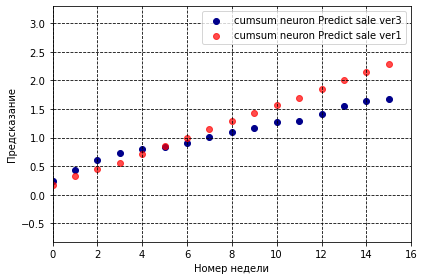

In [11]:
week_forecast = np.arange(16)
err_y_pred_ver3 = np.abs(np.cumsum(y_pred_ver3 - facts, axis=1)).mean(axis=0)
err_y_pred_ver1 = np.abs(np.cumsum(y_pred_ver1 - facts, axis=1)).mean(axis=0)
# err_mwa = np.abs(np.cumsum(rolling_weights_mean_sale - facts, axis=1)).mean(axis=0)
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
lab1= u'cumsum neuron Predict sale ver3'
ax1.scatter(week_forecast, err_y_pred_ver3, color= 'darkblue')
lab2= u'cumsum neuron Predict sale ver1'
ax1.scatter(week_forecast, err_y_pred_ver1, color='red', alpha=0.7)
ax1.set_ylabel('Предсказание')
ax1.set_xlabel('Номер недели') 
ax1.grid(True, axis='y', color='black',  linestyle='dashed')
ax1.grid(True, axis='x', color='black',  linestyle='dashed')
ax1.set_xlim(0, 16)
ax1.set_ylim(np.min([err_y_pred_ver3, err_y_pred_ver1]) - 1, np.max([err_y_pred_ver3, err_y_pred_ver1]) + 1)
ax1.legend((lab1, lab2), frameon=True, loc='best')
plt.tight_layout() 

In [12]:
plt.show()